In [27]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt

In [28]:
path = "C:/data/SiPM/waveforms/20240320/"
filename_list = ["Bi207_data_vb_28V_hithresh_*.pkl",] #"Bi207_data_vb_29V_*.pkl",]
ov_list  = [28,]
data_time = [34,] #time in minutes

In [29]:
ovs_dict = {}
for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))

    data_dict = {}
    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        if(cidx > 100): break
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for k in curr_dict.keys():
                if k == 'time': continue
                data_dict[wfidx] = curr_dict[k]
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = curr_dict['time']

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 100000 waveforms for 2 files: Bi207_data_vb_28V_hithresh_*.pkl


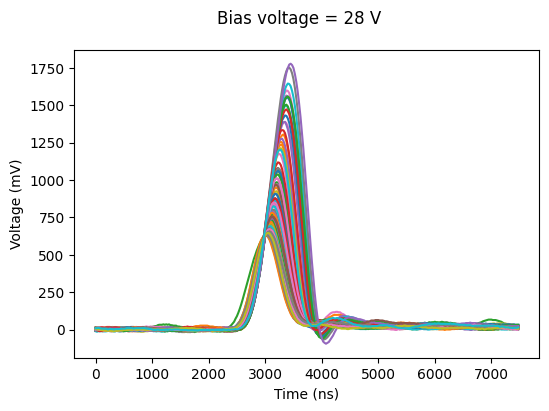

In [30]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(6,4))
        #plt.subplot(1,2,1)
        #for j in range(nwaveforms):
        #    if(j%downsamp != 0): continue
        #    plt.plot(data_dict['time'], data_dict[j][0])
        #    plt.xlabel('Time (ns)')
        #    plt.ylabel('Voltage (mV)')

        #plt.subplot(1,2,2)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j][1])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.suptitle("Bias voltage = %s V"%str(ov))



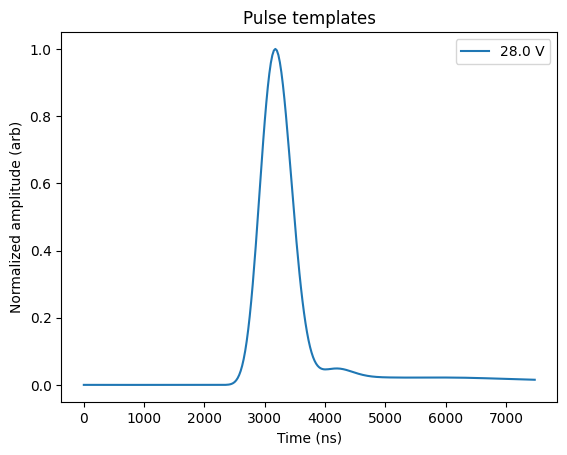

In [31]:
template_dict = {}

plt.figure()
for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template = np.zeros_like(data_dict['time'])

    nwfm = 0
    for j in range(nwaveforms):

        cdat = data_dict[j][1]

        ## throw out bad traces
        #if np.max(cdat) < 600:
        #    continue

        template += cdat
        nwfm += 1

    template /= nwfm
    template -= np.median(template[:100])
    template /= np.max(template)

    plt.plot(data_dict['time'], template, label="%.1f V"%ov)
    plt.xlabel('Time (ns)')
    plt.ylabel('Normalized amplitude (arb)')

    template_dict[ov] = template

plt.title("Pulse templates")
plt.legend()
plt.show()

Working on OV:  28


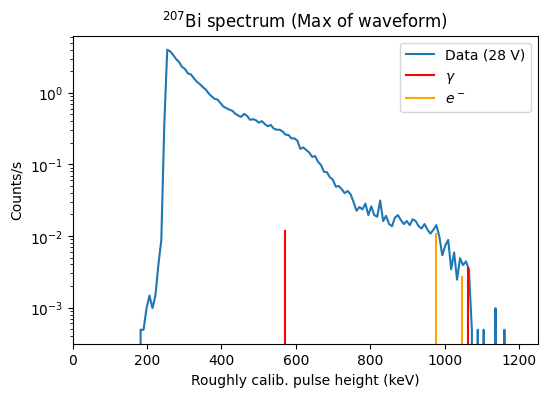

In [72]:
plt.figure(figsize=(6,4))

for oidx, ov in enumerate(ov_list):

    cal_fac = 2.53 ## mV/keV

    print("Working on OV: ", ov)

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    recon_amps = []
    window  = [2500, 4000]

    mpts = (data_dict['time']>window[0]) & (data_dict['time']<window[1])


    for j in range(nwaveforms):

        cdat = data_dict[j][1]
        
        ## baseline subtract
        cdat -= np.median(cdat[:50])

        fit = np.sum( cdat*template ) / np.sum(template**2)

        midx = np.argmax(np.abs(cdat[mpts]))
        max_val = cdat[mpts][midx]
        recon_amps.append( [max_val, fit] )

    recon_amps = np.array(recon_amps)

    bins = np.linspace(0,3500,175)
    bc = bins[:-1] + np.diff(bins)

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    norm = data_time[oidx]*60.0

    #plt.subplot(1,2,1)
    plt.semilogy(bc/cal_fac, h_max/norm, label="Data (%s V)"%str(ov))
    plt.xlim(0,1250)
    plt.xlabel("Roughly calib. pulse height (keV)")
    plt.ylabel("Counts/s")
    plt.title(r"$^{207}$Bi spectrum (Max of waveform)")

    extra_cal = 1100/750 
    #plt.subplot(1,2,2)
    #plt.semilogy(bc/cal_fac * extra_cal, h_fit/norm)
    #plt.xlabel("Uncalib. pulse height (mV)")
    #plt.ylabel("Counts/s")
    #plt.xlim(0,2200)
    #plt.title("Time fit to template")

solid_ang = 0.01
ce_list = [976, 1048]
ce_frac = [0.071*solid_ang, 0.018*solid_ang]

solid_ang = 0.5
gam_list = [570, 1063, 1770]
gam_frac = [0.98*0.09*10/570*solid_ang, 0.75*0.068*10/1063*solid_ang, 0.069]

yy=plt.ylim()

overall_norm = 1.5e1
do_legend = True
for gf,gam in zip(gam_frac, gam_list):
    if(do_legend):
        plt.plot([gam, gam], [yy[0], overall_norm*gf], 'r', label=r"$\gamma$")
        do_legend = False
    else:
        plt.plot([gam, gam], [yy[0], overall_norm*gf], 'r')

do_legend = True
for cf,ce in zip(ce_frac, ce_list):
    if(do_legend):
        plt.plot([ce, ce], [yy[0], overall_norm*cf], 'orange', label=r"$e^-$")
        do_legend = False
    else:
        plt.plot([ce, ce], [yy[0], overall_norm*cf], 'orange')

plt.ylim(yy)
#plt.subplot(1,2,1)
plt.legend()
plt.show()